In [1]:
# Requirements - uncomment as needed
#!pip install matplotlib numpy scipy phyre

# Generating the dataset

The requirement for the dataset here: 

- only using the template that contains only two balls on the scene;

- red ball must be in the free-fall without any collisions other than with the floor;

- only coordinates of the red ball are recorded.

## Playground 2 + Generation

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import math
import re
import itertools
from glob import glob

import phyre

In [3]:
# Choosing a setup where only one ball is needed
eval_setup = 'ball_cross_template'


# We only need one fold as we mix all the data together anyway
fold_id = 0

train_tasks, dev_tasks, test_tasks = phyre.get_fold(eval_setup, fold_id)
tasks = list(train_tasks + dev_tasks + test_tasks)

print('Total tasks: ', len(tasks))

Total tasks:  2500


In [4]:
# Filtering tasks to only include a simple two-ball template. The template key: '00000:xxx'

task_filter = re.compile("00000:*")
tasks = list(filter(task_filter.match, tasks))

print('Tasks after filtering: ', len(tasks))

# Choosing a single scenario in which we will generate our free-falls
tasks = [tasks[0]]

Tasks after filtering:  100


In [5]:
# Getting action tier for our tasks - a single ball
action_tier = phyre.eval_setup_to_action_tier(eval_setup)
print('Action tier for', eval_setup, 'is', action_tier)

Action tier for ball_cross_template is ball


In [6]:
# Create the simulator from the tasks and tier.
simulator = phyre.initialize_simulator(tasks, action_tier)

In [7]:
# getting a 10000 actions from a simulator
# it uniformly samples actions skipping invalid ones
# Action dimensions: 3 (x, y, radius) - represent coordinates and size of the red ball

actions = simulator.build_discrete_action_space(max_actions=10000)

In [8]:
# Defining a function to check if the red ball is in the free fall throughout the simulation
def is_red_ball_in_free_fall(simulation):
    features = simulation.featurized_objects.features
    return False not in [features[0][-1][0] == features[frame_id][-1][0] for frame_id in range(len(features))]

In [28]:
# Getting only the coordinates of the red ball
def get_red_ball_data(simulation):
    features = simulation.featurized_objects.features
    data = []
    for frame_id in range(3, len(features)):
        if frame_id >= 4 and features[frame_id][-1][1] == features[frame_id-4][-1][1]: 
            break
        data.append([features[frame_id-3][-1][1], features[frame_id-2][-1][1], features[frame_id-1][-1][1], features[frame_id][-1][1]])
    return data

In [29]:
# we are using a single task
task_index = 0

for action_index in range(len(actions)):
    simulation = simulator.simulate_action(task_index, actions[action_index], need_images=True, need_featurized_objects=True, stride=15)
    if simulation.status.is_invalid(): continue
    if is_red_ball_in_free_fall(simulation):
        np.save(f'data-free-fall/task-{task_index}-action-{action_index}', get_red_ball_data(simulation))

In [60]:
# DO NOT INCLUDE IT IN THE SCRIPT
# Checking what is in one of the files that I saved
path_glob = glob('data-free-fall/*')
lens = []
for f in path_glob:
    lens.append(len(np.load(f)))

print('Len of lens: ', len(lens))
print('Unique: ', np.unique(lens))
print('Unique counts: ', np.unique(lens, return_counts=True)[1])

Len of lens:  5361
Unique:  [ 2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21]
Unique counts:  [ 29  54  47 181 234 158 175 300 231 209 316 467 418 560 745 572 510  98
  51   6]


In [36]:
sorted(glob('data-free-fall/*'))

['data-free-fall/task-0-action-0.npy',
 'data-free-fall/task-0-action-1.npy',
 'data-free-fall/task-0-action-10.npy',
 'data-free-fall/task-0-action-1001.npy',
 'data-free-fall/task-0-action-1005.npy',
 'data-free-fall/task-0-action-1007.npy',
 'data-free-fall/task-0-action-1009.npy',
 'data-free-fall/task-0-action-1012.npy',
 'data-free-fall/task-0-action-1014.npy',
 'data-free-fall/task-0-action-1015.npy',
 'data-free-fall/task-0-action-1016.npy',
 'data-free-fall/task-0-action-1017.npy',
 'data-free-fall/task-0-action-1018.npy',
 'data-free-fall/task-0-action-1019.npy',
 'data-free-fall/task-0-action-1021.npy',
 'data-free-fall/task-0-action-1024.npy',
 'data-free-fall/task-0-action-1025.npy',
 'data-free-fall/task-0-action-1026.npy',
 'data-free-fall/task-0-action-1029.npy',
 'data-free-fall/task-0-action-103.npy',
 'data-free-fall/task-0-action-1030.npy',
 'data-free-fall/task-0-action-1031.npy',
 'data-free-fall/task-0-action-1032.npy',
 'data-free-fall/task-0-action-1033.npy',
 

# Dataset Class

In [51]:
import torch
from torch.utils.data.dataset import Dataset
from glob import glob
import math
import random
import numpy as np
import re
import os
import phyre
import abc

In [81]:
class ClassicalMechanicsDataset(Dataset, metaclass=abc.ABCMeta):
    def __init__(self, path, data_file_indices=None):
        self.data_path = path

        path_glob = sorted(glob(self.data_path + '/*'))
        self.data_files = np.take(path_glob, data_file_indices) if data_file_indices != None else path_glob
        
    
    def __len__(self):
        return len(self.data_files)
    
    
    def __getitem__(self, idx):
        data = np.load(self.data_files[idx])
        return torch.FloatTensor(data[:, 0:3]), torch.FloatTensor(data[:, 3].reshape(-1,1))

    
    @classmethod
    def train_test_split(dataset_cls, path, test_frac=0):        
        data_glob = glob(path + '/*')
        
        if not data_glob:
            dataset_cls(path).generate_data()
            data_glob = glob(path + '/*')
            
        
        test_size = int(math.floor(test_frac * len(data_glob)))

        if test_size != test_frac * len(data_glob):
            print(f'train_test_split response: test fraction rounded to ' +
                f'{test_size/len(data_glob)} ({test_size} simulations)')

        all_indices = list(range(len(data_glob)))
        test_indices = random.choices(all_indices, k=test_size)
        train_indices = [i for i in all_indices if i not in test_indices]

        
        train_dataset = dataset_cls(path, data_file_indices=train_indices)
        test_dataset = dataset_cls(path, data_file_indices=test_indices)
        
        return (train_dataset, test_dataset)
    
    
    
    @abc.abstractmethod
    def generate_data(self): pass

In [82]:
class OneBallFreeFallThreeFramesDataset(ClassicalMechanicsDataset):
    def generate_data(self):
        # Choosing a setup where only one ball is needed
        eval_setup = 'ball_cross_template'

        # We only need one fold as we mix all the data together anyway
        fold_id = 0

        train_tasks, dev_tasks, test_tasks = phyre.get_fold(eval_setup, fold_id)
        tasks = list(train_tasks + dev_tasks + test_tasks)
        
        # Filtering tasks to only include a simple two-ball template. The template key: '00000:xxx'
        task_filter = re.compile("00000:*")
        tasks = list(filter(task_filter.match, tasks))
        
        # Choosing a single scenario in which we will generate our free-falls
        tasks = [tasks[0]]

        # Getting action tier for our tasks - a single ball
        action_tier = phyre.eval_setup_to_action_tier(eval_setup)
        print('Action tier for', eval_setup, 'is', action_tier)

        # Create the simulator from the tasks and tier.
        simulator = phyre.initialize_simulator(tasks, action_tier)

        # getting a 10000 actions from a simulator
        # it uniformly samples actions skipping invalid ones
        # Action dimensions: 3 (x, y, radius) - represent coordinates and size of the red ball
        actions = simulator.build_discrete_action_space(max_actions=10000)
        
        # Defining a function to check if the red ball is in the free fall throughout the simulation
        def is_red_ball_in_free_fall(simulation):
            features = simulation.featurized_objects.features
            return False not in [features[0][-1][0] == features[frame_id][-1][0] for frame_id in range(len(features))]

        # Getting only the coordinates of the red ball
        def get_red_ball_data(simulation):
            features = simulation.featurized_objects.features
            data = []
            for frame_id in range(3, len(features)):
                if frame_id >= 4 and features[frame_id][-1][1] == features[frame_id-4][-1][1]: 
                    break
                data.append([features[frame_id-3][-1][1], features[frame_id-2][-1][1], features[frame_id-1][-1][1], features[frame_id][-1][1]])
            return data
        
        if not os.path.exists(self.data_path):
            os.makedirs(self.data_path)
        else:
            import glob
            files = glob.glob(self.data_path + '/*')
            for file in files:
                os.remove(file)
        
        for action_index in range(len(actions)):
            simulation = simulator.simulate_action(task_index, actions[action_index], need_images=True, need_featurized_objects=True, stride=15)
            if simulation.status.is_invalid(): continue
            if is_red_ball_in_free_fall(simulation):
                np.save(self.data_path + f'/action-{action_index}', get_red_ball_data(simulation))

In [108]:
train, test = OneBallFreeFallThreeFramesDataset.train_test_split('data-free-fall', test_frac=0.2)

Action tier for ball_cross_template is ball
train_test_split response: test fraction rounded to 0.19996269352732698 (1072 simulations)


In [84]:
train[0]

(tensor([[0.7148, 0.7062, 0.6832],
         [0.7062, 0.6832, 0.6459],
         [0.6832, 0.6459, 0.5942],
         [0.6459, 0.5942, 0.5282],
         [0.5942, 0.5282, 0.4478],
         [0.5282, 0.4478, 0.3530],
         [0.4478, 0.3530, 0.2439],
         [0.3530, 0.2439, 0.1205],
         [0.2439, 0.1205, 0.0127],
         [0.1205, 0.0127, 0.0316],
         [0.0127, 0.0316, 0.0362],
         [0.0316, 0.0362, 0.0265],
         [0.0362, 0.0265, 0.0088],
         [0.0265, 0.0088, 0.0079],
         [0.0088, 0.0079, 0.0079],
         [0.0079, 0.0079, 0.0079]]),
 tensor([[0.6459],
         [0.5942],
         [0.5282],
         [0.4478],
         [0.3530],
         [0.2439],
         [0.1205],
         [0.0127],
         [0.0316],
         [0.0362],
         [0.0265],
         [0.0088],
         [0.0079],
         [0.0079],
         [0.0079],
         [0.0079]]))

## NN Playground

In [85]:
from torch.utils.data import DataLoader

In [86]:
batch_size = 1

train_data, test_data = OneBallFreeFallThreeFramesDataset.train_test_split('data-free-fall', test_frac=0.2)

train_dataloader = DataLoader(dataset=train_data, batch_size=batch_size)
test_dataloader = DataLoader(dataset=test_data, batch_size=batch_size)

train_test_split response: test fraction rounded to 0.19996269352732698 (1072 simulations)


In [93]:
class TestNN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(TestNN, self).__init__()
        self.layer_1=torch.nn.Linear(input_dim, hidden_dim)
        self.layer_2=torch.nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        x = torch.nn.functional.relu(self.layer_1(x))
        x = torch.nn.functional.relu(self.layer_2(x))
        return x

In [94]:
model = TestNN(3, 2, 1)
print(model)

TestNN(
  (layer_1): Linear(in_features=3, out_features=2, bias=True)
  (layer_2): Linear(in_features=2, out_features=1, bias=True)
)


In [99]:
learning_rate = 0.1
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [100]:
num_epochs = 3
loss_values = []

for epoch in range(num_epochs):
    for X, y in train_dataloader:
        optimizer.zero_grad()
        
        pred = model(X)
        loss = loss_fn(pred, y)
        loss_values.append(loss.item())
        loss.backward()
        optimizer.step()

print('Complete!')

Complete!


In [101]:
loss_values

[0.24321681261062622,
 0.15787693858146667,
 0.08096731454133987,
 0.03450452536344528,
 0.0038501834496855736,
 0.020001966506242752,
 0.028406446799635887,
 0.012592516839504242,
 0.01756633073091507,
 0.006413568742573261,
 0.017244631424546242,
 0.012815353460609913,
 0.006051957141608,
 0.0057910168543457985,
 0.013556720688939095,
 0.002772195963189006,
 0.011508838273584843,
 0.003911745734512806,
 0.011093799956142902,
 0.007459211628884077,
 0.004645772278308868,
 0.004473674576729536,
 0.006881581153720617,
 0.005098386667668819,
 0.0016608396545052528,
 0.0013269955525174737,
 0.006406615953892469,
 0.0022668710444122553,
 0.00027279509231448174,
 0.0022023236379027367,
 0.005202115047723055,
 0.0018163785571232438,
 0.0020081622060388327,
 0.00010698445839807391,
 0.0061506181955337524,
 0.0040432121604681015,
 0.0014148979680612683,
 0.0016501244390383363,
 0.0017277286387979984,
 0.0032951063476502895,
 0.0027516300324350595,
 0.0016128402203321457,
 0.004034732468426228,

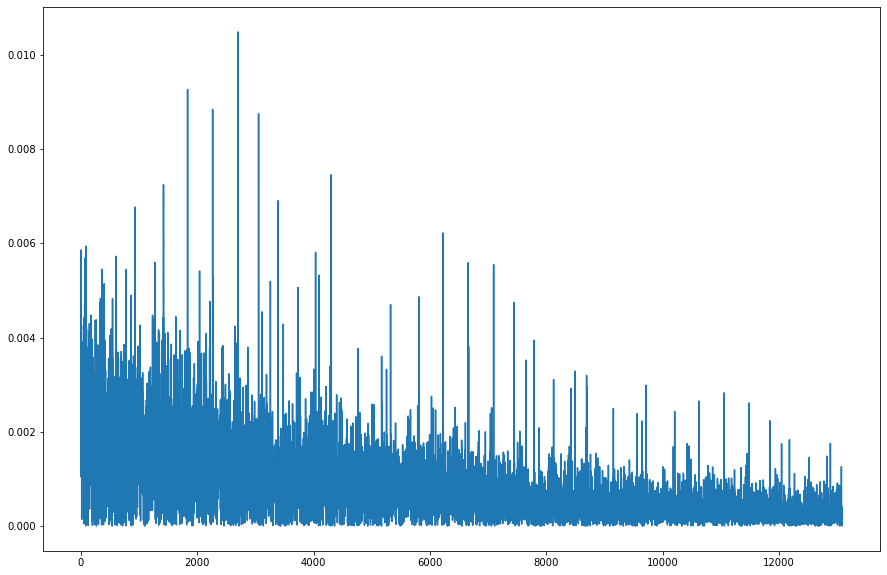

In [107]:
plt.figure(figsize=(15,10))
plt.plot(loss_values[100:])